## Multi-agent reinforcement learning

<small>see sections 1.1 to 1.4 and 5.3 to 5.4 of [Multi-Agent Reinforcement Learning: Foundations and Modern Approaches](https://www.marl-book.com) for a more in-depth overview.</small>

So far we tackled the problem of learning an optimal policy for a single agent inside a MDP, we now shift our focus towards contexts in which there are _multiple_ agents acting in the MDP with (possibly) different goals.

A **multi-agent system** is composed of an environment and multiple decision-making agents, also called _players_, that interact in the environment to achieve certain goals. The environment evolves during play and the players refine their respective strategies, which can be collaborative, competitive or a mix of the two. **multi-agent reinforcement learning** or **MARL** tackles learning in such systems.

As an example, consider a fleet of autonomous vehicles with the goal of driving as quickly and safely as possible, a team of competing players in a videogame or a group of automated traders that manage each their own investments in a public market. See the [environments](https://pettingzoo.farama.org/environments/classic/) from the PettinZoo library for more examples.

At the start of a round of the game, each player sees the state of the environment and picks an action, the round ends after every player has chosen an action, then the envoriment evolves accordingly and each players collects their reward to update their respective policy.

From the point of view of the agent little has changed, they still have a set of actions, a policy, an enviroment and the goal of optimizing their policy. The difference lies in the fact that **the immediate reward achieved by any player depends on the actions of the other players on the same round**.

### The goal of multi-agent reinforcement learning
In the classic RL case, a policy is optimal if it maximises the _return_, defined as the sum of the immediate reward obtained during play, in the multi-agent case, any player's return depends on the other players' actions and ultimately depends on their policies.

**If the return of a policy depends on the other policies, how do we define optimality?** There is no fixed answer to this question, in fact it depends on the underlying context and the objective of the learning procedure, for now we only focus on modeling the problem. To understand the different solutions concepts for MARL we will rely on game-theorical arguments.



### Welcome to the PettingZoo
The Farama foundation, who maintains the Gymnasium library, work also on a MARL-oriented library called [PettingZoo](https://pettingzoo.farama.org/). They share the same interface, which is very useful when, hypothetically, you have been following a course using Gym and now you need to abruptly switch library to cover MARL topics.

Now a couple of examples

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def visualize(render):
	clear_output(wait=True)
	plt.imshow(render)
	plt.show()

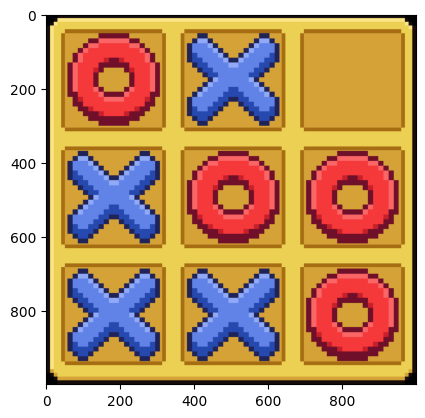

In [12]:
from pettingzoo.classic import tictactoe_v3

env = tictactoe_v3.env(render_mode="rgb_array")
env.reset(seed=42)

for agent in env.agent_iter():
	observation, reward, termination, truncation, info = env.last()
	if termination or truncation:
		action = None
	else:
		# Sample only legal moves
		legal_moves = observation["action_mask"]
		action = env.action_space(agent).sample(legal_moves)

	visualize(env.render())
	env.step(action)

env.close()

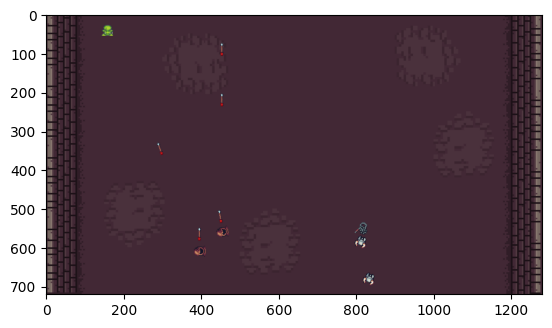

In [13]:
from pettingzoo.butterfly import knights_archers_zombies_v10

env = knights_archers_zombies_v10.env(render_mode="rgb_array")
env.reset(seed=42)

for agent in env.agent_iter(max_iter = 100):
	observation, reward, termination, truncation, info = env.last()
	action = env.action_space(agent).sample()

	visualize(env.render())
	env.step(action)

env.close()